# CHARA Telescope 

This project made up 10% of my part II physics course - it was my first time using data science techniques which were motivated from first principles. The positions of the telescopes in the CHARA array are found with a method which amounts to linear regression. 

Basic knowledge of NumPy, Pandas and Matplotlib is assumed. 

![CHARA array](https://www.chara.gsu.edu/files/images/chara_overview_figure.png)


## What is the problem

### Why should we equalise path length?
The angular resolution of a telescope is the smallest angle between objects that can be visibly resolved and is proportional to the telescope diameter. Although, when using two telescopes together, the angular resolution is set by the distance between the telescopes and not the sizes of the individual telescopes. This means two telescopes that are distance $D$ apart have the same resolving capability (but not light collecting capability) as a larger continuous telescope of diameter $D$. To get the telescope joining benefits, the light in both branches must have travelled the same distance down to the tenths of wavelength to see an image (due to finite coherence lengths, this is explainined clearly in any optics textbook). 

The first telescope to take advantage of this effect was the Michelson stellar interferometer in 1920 when it was set up on Mount Wilson, California to image the star Betelgeuse. Today the Centre for High Angular Resolution Astronomy (CHARA) array sits on Mount Wilson. CHARA consists of six 1m telescopes arranged in a Y-shape (see figure) with baseline distance distances between telescopes ranging from 34m to 330m. It is possible to use measurements from the CHARA array to find the positions of the telescopes relative to each other and find whether there has been significant movement of the telescopes between different dates.


### The physics of this problem is unimportant to understanding the analysis. All you need to know is that there is an equation describing the path difference between two different telescopes. When measurements are taken the path difference vanishes

$$\text{optical path difference}= \hat{\pmb{S}} \cdot (\pmb{r}_1 - \pmb{r}_2) + d_1 - d_2$$

Where $d_i = \text{CART}_i + \text{POP}_i$ is the path difference due to the projection of the sum vector and the optical path length equaliser

So when the optical path difference is zero we get the equation...

$$\text{CART}_2 - \text{CART}_1 = \hat{\pmb{S}} \cdot (\pmb{r}_1 - \pmb{r}_2) + \text{POP}_1 - \text{POP}_2$$

### Matrix equation for a set of measures
This can then be reformed as a matrix equation 

$$y = X \beta$$

$y$ is a vector of the difference in the cart values i.e. the LHS, $\beta$ is a vector of the model parameters, this is the positions of the telescopes and the POP settings used and $X$ is the design matrix (i.e. the coefficients to equations for each measurement)

## Mathematics in depth 

For large data sets, he matrix equation $y = X\beta$ often has more measurements/equations than model parameters/unknowns, i.e. the design matrix is “skinny”. These problems are known as overdetermined.

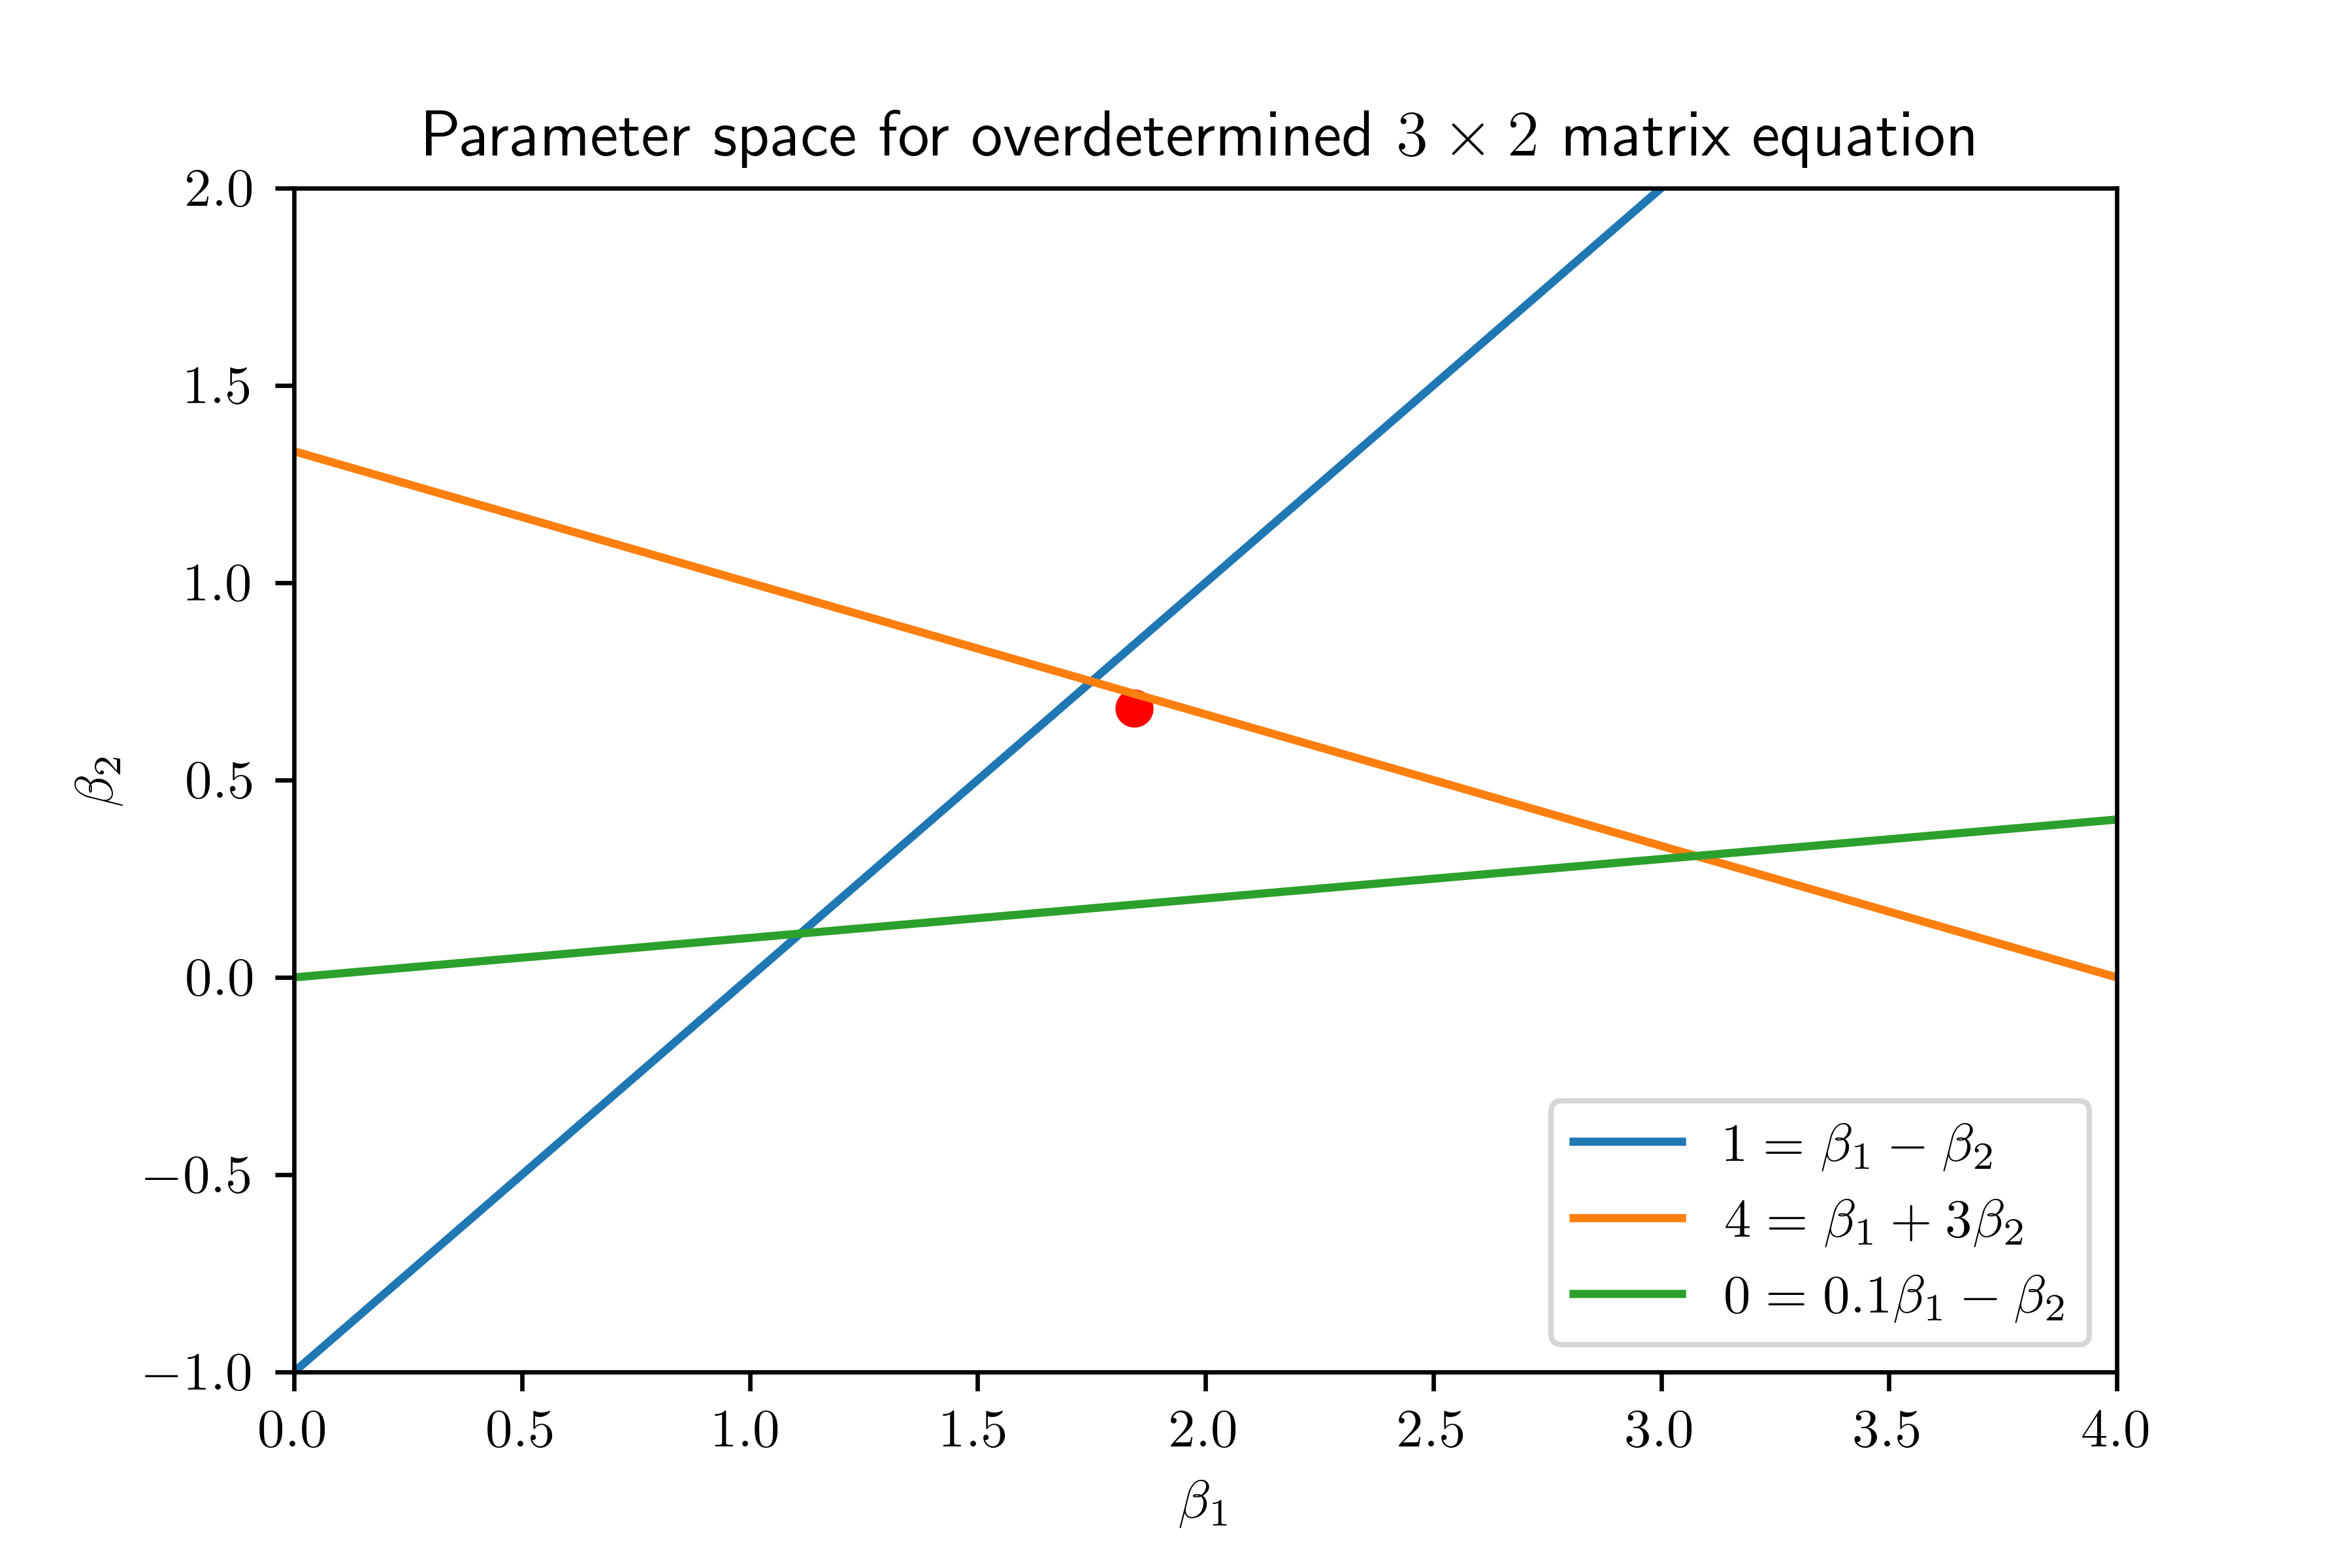

The model parameter space of an overdetermined system can be seen in the figure above, where there are 3 equations for 2 unknowns. There is not a single point in parameter space that satisfies all three equations, i.e $y - X \beta \neq 0$ for all $\beta$. This is equivalent to saying no inverse of $X$ exist (inverses only exist for squares matrices), if one did exist $X^{-1}y = \beta$  and so $y - X(X^{-1}y) = 0$. $y - X\beta$ is the residual vector and is the difference between the data $y$ and the model prediction $X\beta$.

The “best-fit” solution is found via minimising the 2-norm of the residuals, $\|y - Xb \|_2$, with respect to $\beta$. The minimum can be found by assuming a minimum norm value at $\hat{b}$ and taking small perturbations around this point (see appendix A). This gives the solution $X^TX\hat{b} = A^T y$ (this is known as the normal matrix equation) which can rearranged to give the expression an $\hat{\beta}$, as seen in the equation below. $A^+$ is known as the Moore-Penrose inverse or pseudoinverse and is a way of generalising the matrix inverse for non-square matrices. It can be used to find $\hat{b}$.

$$\hat{\beta} = (A^T A)^{-1} A^T y = A^+ y$$

By being the solution to minimising the 2-norm, the pseudoinverse is the solution that minimises the sum of squares of the residuals and is know as ordinary least-squares (OLS). OLS is preferred over other loss functions as it maximises likelihood, though it is very sensitive to outliers so cleaning data is especially important. In the example of the $3 \times 2$  overdetermined matrix, the pseudoinverse gives the point, $\hat{b}$,  which is the OLS from all the solution points and is shown as red dot on the graph. In this project, the Moore-Penrose pseudoinverse was used to find the model parameters. 

**The important thing to takeaway here is that for datasets that are overdetermined, i.e have more datapoints than model parameters. The pseudoinverse is the same as least squares regression and is what linear regression is doing under the hood**

In this problem, our model parameters are the different columns of the design matrix i.e the 15 positions of the telescopes and the values of the pop settings.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Preprocessing 

First of all it is important to have a look at the data and see what is looks like. Ensure that there are no errors or things that could be changed to improve experience

In this example we will be using the data set for the night of April 7th 2019.

In [3]:
df = pd.read_csv('data/original_2019_04_07.csv')

df.head()

,utc,star,elevation,azimuth,tel_1,tel_2,pop_1,pop_2,cart_1,cart_2
0,2019-04-07T03:18:25.000,#93396,282.904832,73.303565,W1,W2,P3B3,P5B2,62.585687,80.000000
1,2019-04-07T03:18:25.000,#93396,282.904832,73.303565,S2,W1,P2B4,P3B3,39.085558,62.585687
2,2019-04-07T03:18:29.000,#93396,282.903948,73.290095,W1,W2,P3B3,P5B2,62.610570,80.000000
3,2019-04-07T03:18:34.000,#93396,282.902857,73.273259,W1,W2,P3B3,P5B2,62.641690,80.000000
4,2019-04-07T03:32:01.000,#93396,282.893761,70.555509,S2,W1,P2B4,P3B3,43.169167,76.216268


In [4]:
# 2034 measurements on this night
df.shape

(2034, 10)

### Things to change 
- UTC text data into a form that is easier to search by 
- Swap elevation and azimuth as these were given the wrong way around
- Swap from degrees to radians as radians are the default angle unit for trig functions in `numpy`

In [5]:
# create seperate columns for year, month, day and dayofyear
dates = pd.to_datetime(df.utc)
df["year"] = [date.year for date in dates]
df["month"] = [date.month for date in dates]
df["day"] = [date.day for date in dates]
df["month"] = [date.month for date in dates]
df["dayofyear"] = [date.day_of_year for date in dates]

# need to swap the elevation and azimuth 
df = df.rename(columns={"elevation": "azimuth", "azimuth": "elevation"})

# change to radians
df["azimuth"] = df["azimuth"] * 2 * np.pi / 360
df["elevation"] = df["elevation"] * 2 * np.pi / 360

df.head()

,utc,star,azimuth,elevation,tel_1,tel_2,pop_1,pop_2,cart_1,cart_2,year,month,day,dayofyear
0,2019-04-07T03:18:25.000,#93396,4.937621,1.279389,W1,W2,P3B3,P5B2,62.585687,80.000000,2019,4,7,97
1,2019-04-07T03:18:25.000,#93396,4.937621,1.279389,S2,W1,P2B4,P3B3,39.085558,62.585687,2019,4,7,97
2,2019-04-07T03:18:29.000,#93396,4.937605,1.279153,W1,W2,P3B3,P5B2,62.610570,80.000000,2019,4,7,97
3,2019-04-07T03:18:34.000,#93396,4.937586,1.278860,W1,W2,P3B3,P5B2,62.641690,80.000000,2019,4,7,97
4,2019-04-07T03:32:01.000,#93396,4.937428,1.231426,S2,W1,P2B4,P3B3,43.169167,76.216268,2019,4,7,97


**The preprocessing for all the other datasets has been complete so you don't need to do it again!**

## Creating the design matrix

### Shape 
We want as many rows as number of measurements but how many columns do we want? 

To represent categorical data in a matrix a model parameter is needed for each category. With six telescopes whose positions can only be known relative to each other there are 15 model parameters for telescope positions (x, y, z) as one telescope, which can be arbitrarily picked (E1), is placed at the origin. There can be a minimum of six POP parameters when each telescope only used one POP settings and up to 180 when all six telescopes use all 30 available POP settings. Note ‘PXBY’ on one telescope is not the same when used on another telescope. Once the number of unique POP settings is found an empty design matrix can be initialised with shape ( data points, 15 + unique POPs).

$$y_i = X_{ij} \beta_j = \hat{\textbf{S}}_i \cdot (\pmb{r}_{i,1} - \pmb{r}_{i,2}) + \text{POP}_{i,1} - \text{POP}_{i,2}$$

** need to add in explanation for all this **

This following will populate a design matrix:

In [8]:
# first need to convert from horizontal coordinates to normal coordinates 
# provide link and a sketch|
theta = df.elevation
phi = df.azimuth
S = np.array(
    [np.cos(theta) * np.sin(phi), np.cos(theta) * np.cos(phi), np.sin(theta)]
).T

# explain the use of `.T`

In [13]:
telescopes = ["E1", "W2", "W1", "S2", "S1", "E2"]

tot_unique_pops = []
width = 15 # 3 spatial coordinates for 5 non-zero telescope

for telescope in telescopes:

    pop_tel_1 = df[df.tel_1 == telescope].pop_1
    pop_tel_2 = df[df.tel_2 == telescope].pop_2
    tel_1_unique_pops = np.unique(pop_tel_2)
    tel_2_unique_pops = np.unique(pop_tel_1)
    tel_unique_pops = np.union1d(tel_1_unique_pops, tel_2_unique_pops)
    tot_unique_pops.append(tel_unique_pops)
    width += len(tel_unique_pops)

design_mat = np.zeros((len(df), width))

design_mat.shape

(2034, 34)

In [14]:
k = 0

for i, telescope in enumerate(telescopes):

    # for ea. new telescope must jump 3 places for (x, y, z)

    if telescope != "E1":  # keep 'E1' as the zero point

        design_mat[:, 3 * i - 3 : 3 + 3 * i - 3] += S * np.where(
            df["tel_1"] == telescope, 1, 0
        ).reshape(-1, 1)
        design_mat[:, 3 * i - 3 : 3 + 3 * i - 3] -= S * np.where(
            df["tel_2"] == telescope, 1, 0
        ).reshape(-1, 1)

    for pop in tot_unique_pops[i]:

        # not working because E1 isn't in the list of telescopes
        design_mat[:, 15 + k] += np.where(
            (df["pop_1"] == pop) & (df["tel_1"] == telescope), 1, 0
        )  # add when it is tel_1
        design_mat[:, 15 + k] -= np.where(
            (df["pop_2"] == pop) & (df["tel_2"] == telescope), 1, 0
        )  # subtract when it is the tel_2

        k += 1

In [15]:
y = df["cart_2"].values - df["cart_1"].values

In [16]:
pinv = np.linalg.pinv(design_mat)

In [23]:
beta = pinv @ y 

beta[:15]

array([194.43260791, 106.59897763,  -6.37520967, 300.40862676,
        89.60984578,   4.88053282, 131.08378955, 272.35384145,
        -6.54767727, 125.33690067, 305.93267805,  -5.90805154,
        54.94397029,  36.20990241,  -3.10685717])

Put here the graph from the original table to show that these results are reasonable 

Talk about what can be achieved from further task with plots over time etc et

As discussed earlier, this is just linear regression! although this is trivial to do in libraries such as `sklearn` you now understand the inner workings of the mathematics behind linear regression.

In [22]:
from sklearn import linear_model 

regr = linear_model.LinearRegression()
regr.fit(design_mat, y).coef_[:15]

array([194.43261114, 106.59898649,  -6.37508527, 300.40865911,
        89.609894  ,   4.88057381, 131.08380509, 272.35393989,
        -6.54766819, 125.33696951, 305.93276828,  -5.90799966,
        54.94395888,  36.20983782,  -3.10685763])

For further reading look at my [report](projectE-hs723.pdf)